#Description

In this approach, firstly, to prepare the data for analysis, we adopted a split of the dataset into training and testing sets (80-20 split). The training data (X_train, Y_train) and testing data (X_test) were immediately encoded using the 'sentence-transformers/all-mpnet-base-v2' sentence transformer. We then applied an Autoencoder, consisting of five layers: 

1. First layer: 768 neurons;
2. Second layer: 256 neurons;
3. Third layer: 100 neurons;
4. Fourth layer: 256 neurons;
5. Fifth layer: 768 neurons

The input and output layers both contain 768 neurons, which is the number of dimensions in a company description after encoding. Our aim was to train the Autoencoder using the X_train and Y_train sets to reduce dimensionality to 100 using the middle (compressed) layer and eliminate unnecessary dimensions when working with other datasets. After several iterations, we found that the Autoencoder achieved optimal results with 10 epochs and a batch size of 32. We then applied the trained Autoencoder to the X_test set to reduce the dimensions and create a new dataset called X_test_compressed.

This compressed dataset was used with the unused Y_test set from before in a new 80-20 train and test split. Note that the Y_test set was not encoded using the sentence transformer.

We trained a OneVsRest Classifier using the Support Vector Classifier (SVC) model with a default rbf kernel and default max_iter.

#Preprocessing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv("/content/drive/MyDrive/companyclassification/datasets/wrds_data.csv")
data.head()

,Unnamed: 0,conm,gind,gsector,naics,busdesc,spcindcd,GICS_Sector,naics_main,NAICS_Sector
0,2,AAI CORP,NaN,NaN,NaN,"AAI Corporation, together with its subsidiarie...",230.0,NaN,No,NaN
1,3,A.A. IMPORTING CO INC,255040.0,25.0,442110.0,"A.A. Importing Company, Inc. designs, manufact...",449.0,Consumer Discretionary,44,Retail Trade
2,4,AAR CORP,201010.0,20.0,423860.0,AAR Corp. provides products and services to co...,110.0,Industrials,42,Wholesale Trade
3,5,A.B.A. INDUSTRIES INC,NaN,NaN,NaN,A.B.A. Industries Inc. was acquired by McSwain...,110.0,NaN,No,NaN
4,6,ABC INDS INC,NaN,NaN,NaN,"ABC Industries, Inc. manufactures and supplies...",415.0,NaN,No,NaN


In [ ]:
data = data[data.columns[2:]]

In [ ]:
data.dropna(subset=['gind'], how='any', inplace=True)

In [ ]:
data['gind'] = data['gind'].astype(int)

In [ ]:
data.drop(columns = ["spcindcd", "naics_main", "NAICS_Sector", "GICS_Sector", "naics", "gsector"], axis=1, inplace=True)

In [ ]:
gics_sector={10: "Energy", 15: "Materials", 20: "Industrials", 25: "Consumer Discretionary (Consumer Cyclical)", 30: "Consumer Staples (Consumer Defensive)", 35: "Health Care", 40: "Financials", 45: "Information Technology", 50: "Communication Services", 55: "Utilities", 60: "Real Estate"}
gics_industry_group={1010: "Energy", 1510: "Materials", 2010: "Capital Goods", 2020: "Commercial & Professional Services", 2030: "Transportation", 2510: "Automobiles & Components", 2520: "Consumer Durables & Apparel", 2530: "Consumer Services", 2550: "Retailing", 3010: "Food & Staples Retailing", 3020: "Food, Beverage & Tobacco", 3030: "Household & Personal Products", 3510: "Health Care Equipment & Services", 3520: "Pharmaceuticals, Biotechnology  & Life Sciences", 4010: "Banks", 4020: "Diversified Financials", 4030: "Insurance", 4510: "Software & Services", 4520: "Technology Hardware & Equipment", 4530: "Semiconductors & Semiconductor Equipment", 5010: "Telecommunication Services", 5020: "Media & Entertainment", 5510: "Utilities", 6010: "Real Estate"}
gics_industry = {101010: "Energy Equipment & Services", 101020: "Oil, Gas & Consumable Fuels", 151010: "Chemicals", 151020: "Construction Materials", 151030: "Containers & Packaging", 151040: "Metals & Mining", 151050: "Paper & Forest Products", 201010: "Aerospace & Defense", 201020: "Building Products", 201030: "Construction & Engineering", 201040: "Electrical Equipment", 201050: "Industrial Conglomerates", 201060: "Machinery", 201070: "Trading Companies & Distributors", 202010: "Commercial Services & Supplies", 202020: "Professional Services", 203010: "Air Freight & Logistics", 203020: "Airlines", 203030: "Marine", 203040: "Road & Rail", 203050: "Transportation Infrastructure", 251010: "Auto Components", 251020: "Automobiles", 252010: "Household Durables", 252020: "Leisure Products", 252030: "Textiles, Apparel & Luxury Goods", 253010: "Hotels, Restaurants & Leisure", 253020: "Diversified Consumer Services", 255010: "Distributors", 255020: "Internet & Direct Marketing Retail", 255030: "Multiline Retail", 255040: "Specialty Retail", 301010: "Food & Staples Retailing", 302010: "Beverages", 302020: "Food Products", 302030: "Tobacco", 303010: "Household Products", 303020: "Personal Products", 351010: "Health Care Equipment & Supplies", 351020: "Health Care Providers & Services", 351030: "Health Care Technology", 352010: "Biotechnology", 352020: "Pharmaceuticals", 352030: "Life Sciences Tools & Services", 401010: "Banks", 401020: "Thrifts & Mortgage Finance", 402010: "Diversified Financial Services", 402020: "Consumer Finance", 402030: "Capital Markets", 402040: "Mortgage Real Estate Investment Trusts (REITs)", 403010: "Insurance", 451020: "IT Services", 451030: "Software", 452010: "Communications Equipment", 452020: "Technology Hardware, Storage & Peripherals", 452030: "Electronic Equipment, Instruments & Components", 453010: "Semiconductors & Semiconductor Equipment", 501010: "Diversified Telecommunication Services", 501020: "Wireless Telecommunication Services", 502010: "Media", 502020: "Entertainment", 502030: "Interactive Media & Services", 551010: "Electric Utilities", 551020: "Gas Utilities", 551030: "Multi-Utilities", 551040: "Water Utilities", 551050: "Independent Power and Renewable Electricity Producers", 601010: "Equity Real Estate Investment Trusts (REITs)", 601020: "Real Estate Management & Development"}
##############We do not have data for sub industry###############################
gics_sub_industry={10101010: "Oil & Gas Drilling", 10101020: "Oil & Gas Equipment & Services", 10102010: "Integrated Oil & Gas", 10102020: "Oil & Gas Exploration & Production", 10102030: "Oil & Gas Refining & Marketing", 10102040: "Oil & Gas Storage & Transportation", 10102050: "Coal & Consumable Fuels", 15101010: "Commodity Chemicals", 15101020: "Diversified Chemicals", 15101030: "Fertilizers & Agricultural Chemicals", 15101040: "Industrial Gases", 15101050: "Specialty Chemicals", 15102010: "Construction Materials", 15103010: "Metal & Glass Containers", 15103020: "Paper Packaging", 15104010: "Aluminum", 15104020: "Diversified Metals & Mining", 15104025: "Copper", 15104030: "Gold", 15104040: "Precious Metals & Minerals", 15104045: "Silver", 15104050: "Steel", 15105010: "Forest Products", 15105020: "Paper Products", 20101010: "Aerospace & Defense", 20102010: "Building Products", 20103010: "Construction & Engineering", 20104010: "Electrical Components & Equipment", 20104020: "Heavy Electrical Equipment", 20105010: "Industrial Conglomerates", 20106010: "Construction Machinery & Heavy Trucks", 20106015: "Agricultural & Farm Machinery", 20106020: "Industrial Machinery", 20107010: "Trading Companies & Distributors", 20201010: "Commercial Printing", 20201050: "Environmental & Facilities Services", 20201060: "Office Services & Supplies", 20201070: "Diversified Support Services", 20201080: "Security & Alarm Services", 20202010: "Human Resource & Employment Services", 20202020: "Research & Consulting Services", 20301010: "Air Freight & Logistics", 20302010: "Airlines", 20303010: "Marine", 20304010: "Railroads", 20304020: "Trucking", 20305010: "Airport Services", 20305020: "Highways & Railtracks", 20305030: "Marine Ports & Services", 25101010: "Auto Parts & Equipment", 25101020: "Tires & Rubber", 25102010: "Automobile Manufacturers", 25102020: "Motorcycle Manufacturers", 25201010: "Consumer Electronics", 25201020: "Home Furnishings", 25201030: "Homebuilding", 25201040: "Household Appliances", 25201050: "Housewares & Specialties", 25202010: "Leisure Products", 25203010: "Apparel, Accessories & Luxury Goods", 25203020: "Footwear", 25203030: "Textiles", 25301010: "Casinos & Gaming", 25301020: "Hotels, Resorts & Cruise Lines", 25301030: "Leisure Facilities", 25301040: "Restaurants", 25302010: "Education Services", 25302020: "Specialized Consumer Services", 25501010: "Distributors", 25502020: "Internet & Direct Marketing Retail", 25503010: "Department Stores", 25503020: "General Merchandise Stores", 25504010: "Apparel Retail", 25504020: "Computer & Electronics Retail", 25504030: "Home Improvement Retail", 25504040: "Specialty Stores", 25504050: "Automotive Retail", 25504060: "Homefurnishing Retail", 30101010: "Drug Retail", 30101020: "Food Distributors", 30101030: "Food Retail", 30101040: "Hypermarkets & Super Centers", 30201010: "Brewers", 30201020: "Distillers & Vintners", 30201030: "Soft Drinks", 30202010: "Agricultural Products", 30202030: "Packaged Foods & Meats", 30203010: "Tobacco", 30301010: "Household Products", 30302010: "Personal Products", 35101010: "Health Care Equipment", 35101020: "Health Care Supplies", 35102010: "Health Care Distributors", 35102015: "Health Care Services", 35102020: "Health Care Facilities", 35102030: "Managed Health Care", 35103010: "Health Care Technology", 35201010: "Biotechnology", 35202010: "Pharmaceuticals", 35203010: "Life Sciences Tools & Services", 40101010: "Diversified Banks", 40101015: "Regional Banks", 40102010: "Thrifts & Mortgage Finance", 40201020: "Other Diversified Financial Services", 40201030: "Multi-Sector Holdings", 40201040: "Specialized Finance", 40202010: "Consumer Finance", 40203010: "Asset Management & Custody Banks", 40203020: "Investment Banking & Brokerage", 40203030: "Diversified Capital Markets", 40203040: "Financial Exchanges & Data", 40204010: "Mortgage REITs", 40301010: "Insurance Brokers", 40301020: "Life & Health Insurance", 40301030: "Multi-line Insurance", 40301040: "Property & Casualty Insurance", 40301050: "Reinsurance", 45102010: "IT Consulting & Other Services", 45102020: "Data Processing & Outsourced Services", 45102030: "Internet Services & Infrastructure", 45103010: "Application Software", 45103020: "Systems Software", 45201020: "Communications Equipment", 45202030: "Technology Hardware, Storage & Peripherals", 45203010: "Electronic Equipment & Instruments", 45203015: "Electronic Components", 45203020: "Electronic Manufacturing Services", 45203030: "Technology Distributors", 45301010: "Semiconductor Equipment", 45301020: "Semiconductors", 50101010: "Alternative Carriers", 50101020: "Integrated Telecommunication Services", 50102010: "Wireless Telecommunication Services", 50201010: "Advertising", 50201020: "Broadcasting", 50201030: "Cable & Satellite", 50201040: "Publishing", 50202010: "Movies & Entertainment", 50202020: "Interactive Home Entertainment", 50203010: "Interactive Media & Services", 55101010: "Electric Utilities", 55102010: "Gas Utilities", 55103010: "Multi-Utilities", 55104010: "Water Utilities", 55105010: "Independent Power Producers & Energy Traders", 55105020: "Renewable Electricity", 60101010: "Diversified REITs", 60101020: "Industrial REITs", 60101030: "Hotel & Resort REITs", 60101040: "Office REITs", 60101050: "Health Care REITs", 60101060: "Residential REITs", 60101070: "Retail REITs", 60101080: "Specialized REITs", 60102010: "Diversified Real Estate Activities", 60102020: "Real Estate Operating Companies", 60102030: "Real Estate Development", 60102040: "Real Estate Services"}

In [ ]:
import math

temp = []
for item in data["gind"]:
  temp.append(math.floor(item/10000))

data["gind"] = temp

In [ ]:
import re
import string

def preprocess_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)

    return text

In [ ]:
data["busdesc"] = data["busdesc"].map(preprocess_text)

In [ ]:
sectors = []

for item in list(data["gind"]):
  sectors.append(gics_sector[item])

data["gind"] = sectors

In [ ]:
data.head()

,gind,busdesc
1,Consumer Discretionary (Consumer Cyclical),aa importing company inc designs manufactures ...
2,Industrials,aar corp provides products and services to com...
5,Consumer Discretionary (Consumer Cyclical),abkco music records inc operates as an entert...
6,Materials,makes cold and warm forgings including transmi...
7,Industrials,acf industries llc operates as a machinery con...


In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=7c61546a93d433ed69cece2d89e966dcee574c175d5ac9be3d980439d6228ed1
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


#Train and test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data["busdesc"], data["gind"], test_size=0.2, random_state=0)

#Autoencoder

In [ ]:
import keras
import tensorflow as tf

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

# Define the input size
input_size = 768

# Define the encoder layers
input_layer = Input(shape=(input_size,))
encoder_layer1 = Dense(256, activation='relu')(input_layer)
encoder_layer2 = Dense(100, activation='relu')(encoder_layer1)

# Define the decoder layers
decoder_layer1 = Dense(256, activation='relu')(encoder_layer2)
decoder_layer2 = Dense(input_size, activation='relu')(decoder_layer1)

# Define the Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder_layer2)

# Define the encoder model (for compression)
encoder = Model(inputs=input_layer, outputs=encoder_layer2)

# Define the decoder model (for decompression)
# decoder_input = Input(shape=(100,))
# decoder_layer3 = autoencoder.layers[-2](decoder_input)
# decoder_layer4 = autoencoder.layers[-1](decoder_layer3)
decoder = Model(inputs=encoder_layer2, outputs=decoder_layer2)

# Compile the Autoencoder model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

#Encoding the sentences

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
X_train = model.encode(list(X_train))
Y_train = model.encode(list(Y_train))
X_test = model.encode(list(X_test))

#Training the autoencoder

In [ ]:
# Train the Autoencoder
num_epochs = 10
batch_size = 32
autoencoder.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size)

Epoch 1/10
859/859 [==============================] - 4s 4ms/step - loss: 8.7836e-04
Epoch 2/10
859/859 [==============================] - 2s 3ms/step - loss: 8.1778e-04
Epoch 3/10
859/859 [==============================] - 4s 4ms/step - loss: 8.0038e-04
Epoch 4/10
859/859 [==============================] - 3s 4ms/step - loss: 7.8603e-04
Epoch 5/10
859/859 [==============================] - 2s 3ms/step - loss: 7.7312e-04
Epoch 6/10
859/859 [==============================] - 3s 3ms/step - loss: 7.6103e-04
Epoch 7/10
859/859 [==============================] - 3s 3ms/step - loss: 7.5123e-04
Epoch 8/10
859/859 [==============================] - 3s 4ms/step - loss: 7.4292e-04
Epoch 9/10
859/859 [==============================] - 3s 4ms/step - loss: 7.3634e-04
Epoch 10/10
859/859 [==============================] - 3s 3ms/step - loss: 7.3080e-04


In [ ]:
# Test the Autoencoder
X_test_input = X_test
X_test_compressed = encoder.predict(X_test_input)
X_test_output = decoder.predict(X_test_compressed)

215/215 [==============================] - 0s 1ms/step


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
Y_test = encoder.fit_transform(list(Y_test))
set(Y_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [ ]:
my_tags = list(gics_sector.values())
len(my_tags)

11

#New train and test split

In [ ]:
X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(X_test_compressed, Y_test, test_size=0.2, random_state=0)

#OneVsRest Classifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC())

clf.fit(X_train_new, Y_train_new)

y_pred = clf.predict(X_test_new)

#Results

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

print(confusion_matrix(Y_test_new, y_pred))
print(classification_report(Y_test_new, y_pred, target_names=my_tags))
print("F1 score is: "+ (str)(f1_score(Y_test_new, y_pred, average='micro')))

[[ 18  13   0   0   1   2   1  15   0   0   0]
 [  7 140   8   0   3   1  14  20   1   1   1]
 [  0   2  31   0   0   9   1   0   4   0   1]
 [  0   0   1  94   1   0   4   1   1   0   2]
 [  0   5   0   2 194   3   2   4   1   1   2]
 [  1   3   0   1   3 160   1   2   0   0   0]
 [  2  18   1   2   6   5  63  20  12   0   2]
 [  5  12   0   1   2   7   9 185   2   1   0]
 [  0   6   2   8   2   2  10   1 152   0   0]
 [  1   3   0   0   8   0   0   0   0   8   0]
 [  0   0   0   6   0   0   3   0   0   0  24]]
                                            precision    recall  f1-score   support

                                    Energy       0.53      0.36      0.43        50
                                 Materials       0.69      0.71      0.70       196
                               Industrials       0.72      0.65      0.68        48
Consumer Discretionary (Consumer Cyclical)       0.82      0.90      0.86       104
     Consumer Staples (Consumer Defensive)       0.88      0.

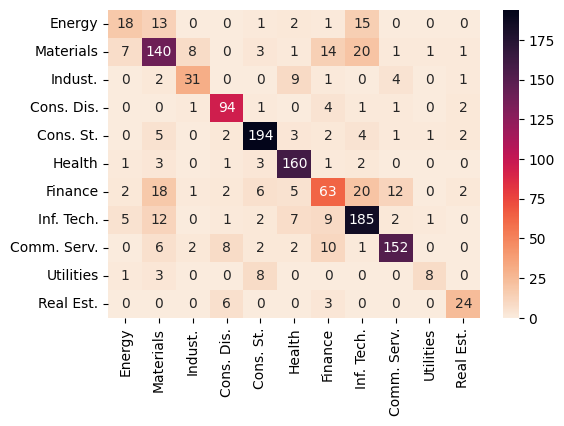